# Implement Spatial Pooler

В данной тетради требуется реализовать Spatial Pooler по аналогии с [описанием](https://numenta.com/assets/pdf/spatial-pooling-algorithm/Spatial-Pooling-Algorithm-Details.pdf) и [статьёй](https://www.frontiersin.org/articles/10.3389/fncom.2017.00111/pdf) от нументы. Данная тетрадь сделана на основе [примера](https://github.com/htm-community/htm.core/blob/master/py/htm/examples/mnist.py) из нументовского фреймворка `htm.core`. Сам их фреймворк нам здесь не понадобится — его ставить не нужно, но можешь ради интереса к тестам ниже добавить и тест эталонной реализации Spatial Pooler.

Для начала посмотри эпизоды 0-8 видео гайда [HTMSchool](https://www.youtube.com/watch?v=XMB0ri4qgwc&list=PL3yXMgtrZmDqhsFQzwUC9V8MeeVOQ7eZ9).

## 01. Getting ready

Данная секция содержит:

- импорт необходимых пакетов (убедись, что все они установлены)
- загрузка датасета

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
%matplotlib inline

seed = 1337

### Load data

Следующая ячейка загружает датасет MNIST (займет порядка 10-20 сек).

In [2]:
def load_ds(rng, name, num_test, shape=None):
    """
    fetch dataset from openML.org and split to train/test
    @param name - ID on openML (eg. 'mnist_784')
    @param num_test - num. samples to take as test
    @param shape - new reshape of a single data point (ie data['data'][0]) as a list. Eg. [28,28] for MNIST
    """
    data = fetch_openml(name, version=1, parser='auto')
    sz=data['target'].shape[0]

    X = np.array(data['data'])
    if shape is not None:
        new_shape = shape.insert(0, sz)
        X = np.reshape(X, shape)

    y = np.array(data['target']).astype(np.int32)
    print(X.shape, y.shape)

    indices = rng.permutation(y.size)
    X = X[indices, :, :]
    y = y[indices]

    # split to train/test data
    train_labels = y[:sz-num_test]
    train_images = X[:sz-num_test]
    test_labels  = y[sz-num_test:]
    test_images  = X[sz-num_test:]

    return train_labels, train_images, test_labels, test_images

rng = np.random.default_rng(seed)
train_labels, train_images, test_labels, test_images = load_ds(rng, 'mnist_784', 10000, shape=[28,28])

n_train_samples = train_images.shape[0]
n_test_samples = test_images.shape[0]
image_shape = train_images[0].shape
image_side = image_shape[0]
image_size = image_side ** 2


train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

(70000, 28, 28) (70000,)


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Пример формата данных датасета

Label: 5
Image shape: (28, 28)
Image middle row: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 145 253  53   0   0   0   0   0   0   0]


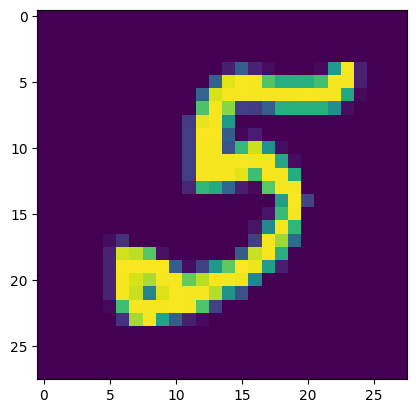

In [3]:
ind = 1
plt.imshow(train_images[ind])
print(f'Label: {train_labels[ind]}')
print(f'Image shape: {image_shape}')
print(f'Image middle row: {train_images[ind][image_side//2]}')

Перекодируем датасет в бинарные изображения и дальше будем работать с бинарными данными.

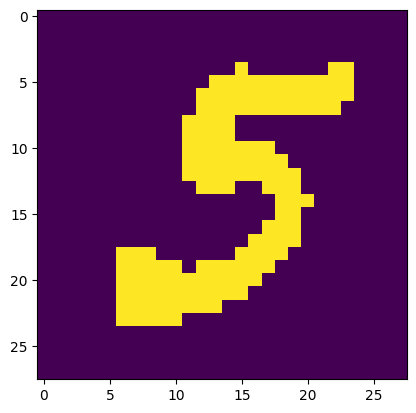

In [4]:
def plot_flatten_image(flatten_image, image_height=28):
    plt.imshow(flatten_image.reshape((image_height, -1)))

def to_binary_flatten_images(images):
    n_samples = images.shape[0]
    # flatten every image to vector
    images = images.reshape((n_samples, -1))
    # binary encoding: each image pixel is encoded either 0 or 1 depending on that image mean value
    images = (images >= images.mean(axis=1, keepdims=True)).astype(np.int8)
    return images


train_images = to_binary_flatten_images(train_images)
test_images = to_binary_flatten_images(test_images)
plot_flatten_image(train_images[ind])

## 02. Baseline: classifier on raw input

В качестве бейзлайна возьмем стандартный sklearn'овский логрег классификатор

In [5]:
LBFGS_MAX_ITER = 1_000

In [6]:
%%time

def test_bare_classification(x_tr,  y_tr, x_tst, y_tst):
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=1)
    linreg.fit(x_tr, y_tr)

    score = linreg.predict(x_tst) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}%')
    return score

np.random.seed(seed)
# for debug purposes I chose smaller subset of the train/test set, you can set the whole set of 60k training samples
n = 1_000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

# примерные/ориентировочные результаты
# 1k: 87.4; 888ms
# 60k: 91.4; 1.5min
_ = test_bare_classification(x_tr, y_tr, x_tst, y_tst)

Score: 87.4%
CPU times: total: 2.08 s
Wall time: 907 ms


## 03. Spatial Pooler: skeleton

Временно сделаем пустой класс Spatial Pooler'а заглушку, чтобы дальше ввести весь необходимый auxiliary код для обучения и тестирования.

In [7]:
class NoOpSpatialPooler:
    def __init__(self, input_size):
        self.input_size = input_size
        self.output_size = input_size

    def compute(self, dense_sdr, learn):
        # просто отдает вход на выход
        return np.flatnonzero(dense_sdr)


np.random.seed(seed)
sp = NoOpSpatialPooler(train_images[0].size)
sparse_sdr = sp.compute(train_images[0], True)

print(sparse_sdr.size, sp.output_size)
assert sparse_sdr.size < sp.output_size

91 784


## 04. Train/test SP performance aux pipeline

Ниже непосредственно код для обучения и тестирования классификации с использованием Spatial Pooler'а. Общая схема следующая - мы обучаем SP на train set'е, а дальше SDR векторы на выходе из SP используем в кач-ве входных данных для логрег классификатора в надежде, что эти данные разделимы еще лучше, то есть что качество классификации улучшится.

__NB__: Не удивляйся, в реализации ниже обучение идет в немного полуонлайн режиме - делается небольшой претрейн, а потом полностью онлайн. Претрейн делаем для прогрева SP, тк на ранних стадиях обучения он слишком сильно меняет выходную кодировку.

In [8]:
%%time

def pretrain_sp(sp, images, n_samples):

    for img in images[:n_samples]:
        sp.compute(img, True)

def encode_to_csr_with_sp(images, sp, learn):
    flatten_encoded_sdrs = []
    indptr = [0]
    for img in images:
        encoded_sparse_sdr = sp.compute(img, learn)
        flatten_encoded_sdrs.extend(encoded_sparse_sdr)
        indptr.append(len(flatten_encoded_sdrs))

    data = np.ones(len(flatten_encoded_sdrs))
    csr = csr_matrix((data, flatten_encoded_sdrs, indptr), shape=(images.shape[0], sp.output_size))
    return csr

def test_classification_with_sp(x_tr,  y_tr, x_tst, y_tst, sp):
    # a small pretrain SP before real work
    pretrain_sp(sp, x_tr, n_samples=1000)

    # encode images and continuously train SP
    csr = encode_to_csr_with_sp(x_tr, sp, learn=True)

    # train linreg
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=3)
    linreg.fit(csr, y_tr)

    # encode test images (without SP learning) and then test score
    csr = encode_to_csr_with_sp(x_tst, sp, False)
    score = linreg.predict(csr) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}% for n = {len(x_tr)}')
    return score

n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]
my_sp = NoOpSpatialPooler(train_images[0].size)

# 87.3; 1.16s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, my_sp)

Score: 87.4% for n = 1000
CPU times: total: 219 ms
Wall time: 7.07 s


0.874

## 05. Spatial Pooler: learning

__Здесь начинается практическое задание__

В этой части требуется реализовать простую версию SP с обучением как описано в видео htm scool до бустинга (т.е. бустинг пока не нужен).

In [9]:
class LearnableSpatialPooler:
    def __init__(
        self, input_size, output_size, permanence_threshold, output_sparsity, synapse_permanence_deltas, receptive_field_sparsity
    ):
        '''
        params:
            `input_size` - the size of the input SDR
            `output_size` - the size of the output SDR
            `permanence_threshold` - value in [0, 1], defines whether or not a connection is active
            `output_sparsity` - value in [0, 1], defines desired output SDR sparsity, e.g. 0.02 is 2% sparsity
            `synapse_permanence_deltas` - tuple of (p+, p-), defines permanence increment/decrement for learning
            `receptive_field_sparsity` - value in [0, 1], defines the fraction of _potential_ synapses
        '''
        self.input_size = input_size
        self.output_size = output_size
        self.permanence_threshold = permanence_threshold
        self.output_sparsity = output_sparsity
        self.p_increment, self.p_decrement = synapse_permanence_deltas
        self.receptive_field_sparsity = receptive_field_sparsity

        # number of potential synapses
        self.n_potential_synapses = int(input_size*receptive_field_sparsity)

        # indices of potential synapses
        self.potential_synapses_idx = np.stack([np.random.choice(input_size, self.n_potential_synapses, replace=False) for _ in range(output_size)])

        # Note: instead of synapses (associated with one column) representing a subset of input, I considered them representing the whole input for simplicity
        # defining synapses permanence within a small range aroung permanence threshold
        self.synapses_permanence = np.random.uniform(permanence_threshold-0.1,permanence_threshold+0.1,size=(output_size,self.n_potential_synapses))

        # defining number of "activated columns"
        self.n_active_bits = int(output_sparsity * output_size)

        # defining activation frequency
        self.cols_activation_freq = np.zeros(output_size)

        # counting how many times learning will be done
        self.count = 0

    def compute(self, dense_sdr, learn):
        '''
        params:
            `dense_sdr` - input SDR in dense for, i.e. as np.array
            `learn` - bool flag, whether or not to do a learning step

        returns:
            a list of activated columns indices
        '''

        # defining "active_synapses"; a binary matrix with 1 = active synapse and 0 = inactive synapse
        active_synapses = (self.synapses_permanence>self.permanence_threshold)*dense_sdr[self.potential_synapses_idx]

        # defining "overlap scores"; number of "active synapses" in each column
        overlap_scores = np.sum(active_synapses, axis=1)

        ## global inhibition process
        # indices of "n_active_bits" columns with maximum overlap scores
        activated_cols = np.argpartition(overlap_scores,-self.n_active_bits)[-self.n_active_bits:]

        ## learning process
        if learn:
            self.count += 1
            for col in activated_cols:
                # incrementing permanence for active synapse
                self.synapses_permanence[col, active_synapses[col,:]==1] += self.p_increment
                # decrementing permanence for inactive synapse
                self.synapses_permanence[col, active_synapses[col,:]==0] -= self.p_decrement

            # clipping permanence values to be within [0,1]
            self.synapses_permanence = np.clip(self.synapses_permanence, 0, 1)

            # updating activation frequency
            self.cols_activation_freq[activated_cols] += 1
            
        # returning indices of active columns
        return activated_cols

np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=10**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8
)

sparse_sdr = sp.compute(train_images[0], True)

print(sparse_sdr.size, sp.output_size, sp.n_active_bits)
assert sparse_sdr.size == sp.n_active_bits
sparse_sdr

4 100 4


array([16, 44, 30, 22], dtype=int64)

### 05.1. Naive SP performance

Проверь качество работы своей реализации. В комментариях примерные значения для разных `n`, на которые можно попробовать ориентироваться:

In [10]:
%%time

np.random.seed(seed)
n = 1_000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8
)
# 1k: 80.2; 2.98s
# 60k: 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 86.3% for n = 1000
CPU times: total: 37.8 s
Wall time: 42.3 s


0.863

Интересная метрика оценки качества работы SP и вырожденности датасета - энтропия выходных активаций.

Добавь либо в реализацию класса, либо где-то сбоку возможность учета статистики активаций выходных клеток (ты наверняка заметил, что обычно их контринтуитивно называют столбцами, что оч круто запутывает) и функцию подсчета энтропии на основе этой статистики. Собери такую статистику на одном прогоне на всем датасете и:

- нарисуй гистограмму частоты активаций (с нормализацией, чтобы по оси Y были вероятности активации, а не их число)
- посчитай энтропию $H = -\sum p \cdot \log p$

In [11]:
def plot_activation_prob(activation_freq,divider):
    # calculating activation probabilities
    activation_prob = activation_freq/divider

    # calculating entropy
    entropy = -np.sum(activation_prob*np.log2(activation_prob+1e-6))
    print(f"Entropy: {entropy:.4f}")

    # plotting activation frequency of columns
    plt.figure(figsize=(15,10))
    plt.bar(range(sp.output_size),activation_prob)
    plt.xlabel("Columns")
    plt.ylabel("Activation Probability")
    plt.title("Activation Frequency of Columns")
    plt.show()

Entropy: 151.4776


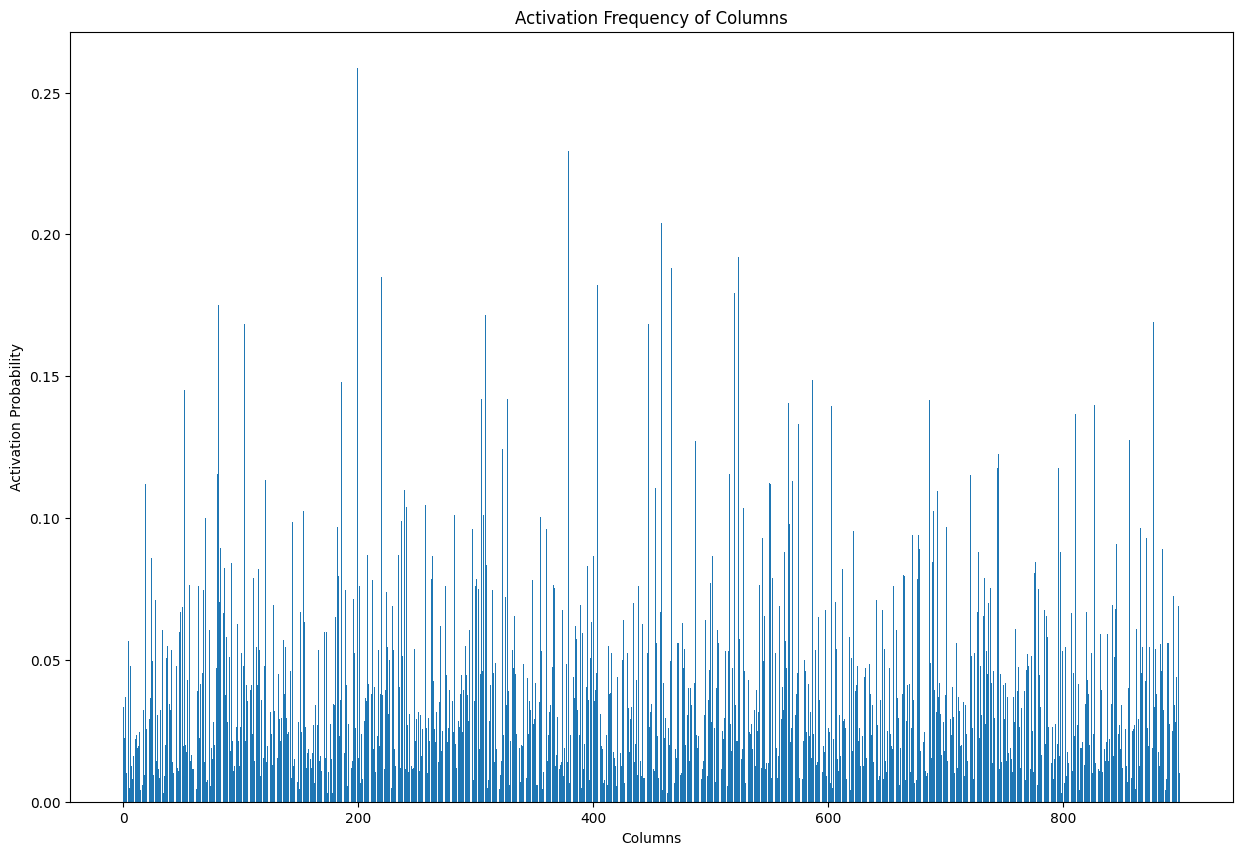

In [12]:
plot_activation_prob(sp.cols_activation_freq,sp.count)

Теперь давай посмотрим, как выходной размер `output_size` влияет на качество работы. Протестируй разные значения `output_size` - например, $[10^2, 15^2,..., 55^2, 60^2]$ и отрисуй график зависимости [качества классификации, но можешь и времени работы тоже].

_Можно для начала прикинуть для n=1000 и двигаться дальше, а позже пересчитать на всем датасете_

In [13]:
def quality_vs_output_size(output_sizes,scores,processing_time):
    _, ax = plt.subplots(1,2,figsize=(15,10))
    plt.subplots_adjust(wspace=0.3)

    ax[0].plot(output_sizes,scores)
    # ax[0].set_xlabel("Output Sizes")
    ax[0].set_ylabel("Score (%)")
    # ax[0].set_title("Score vs. Output Size")

    ax[1].plot(output_sizes,processing_time)
    # ax[1].set_xlabel("Output Sizes")
    ax[1].set_ylabel("Processing Time (sec)")
    # ax[1].set_title("Processing Time vs. Output Size")

Score: 69.3% for n = 1000
Score: 77.2% for n = 1000
Score: 83.1% for n = 1000
Score: 85.1% for n = 1000
Score: 86.9% for n = 1000
Score: 86.3% for n = 1000
Score: 87.7% for n = 1000
Score: 89.3% for n = 1000
Score: 89.1% for n = 1000
Score: 88.8% for n = 1000
Score: 89.9% for n = 1000
CPU times: total: 10min 45s
Wall time: 11min 19s


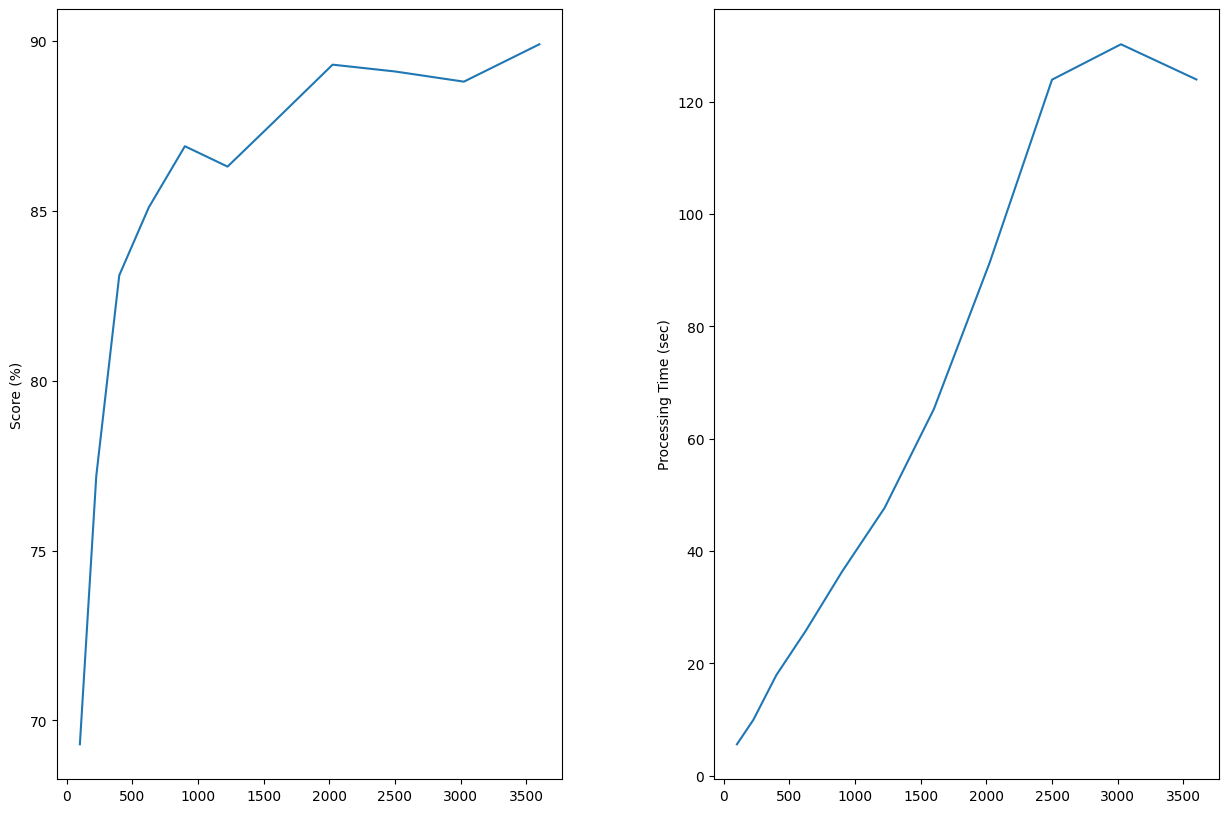

In [14]:
%%time
np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

output_sizes = [i**2 for i in range(10,65,5)]

scores = []
processing_time = []
for output_size in output_sizes:
  sp = LearnableSpatialPooler(
      input_size=train_images[0].size,
      output_size=output_size,
      permanence_threshold=.5,
      output_sparsity=.04,
      synapse_permanence_deltas=(.1, .03),
      receptive_field_sparsity=.8
      )
  start_time = time.time()
  score = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
  processing_time.append((time.time()-start_time))
  scores.append(score*100)


quality_vs_output_size(output_sizes,scores,processing_time)

## 06. Spatial Pooler: boosting

В этом пункте требуется реализовать бустинг. Обрати внимание, в видео htm school речь ведется о бустинге overlap score на основе активности выходных ячеек -  именно такой вид бустинга и нужно реализовать. Еще есть бустинг значений permanence синапсов выходных ячеек, имеющих слишком низкое среднее значение overlap score за последние N итераций - рассмотрение этого вида бустинга оставим в стороне. Так что дальше под бустингом будет иметься в виду только первый вариант.

Зададим параметр `max_boost_factor` $\in [0, +\infty)$. Можно по-разному задавать интерпретацию этого параметра, то есть как будет действовать бустинг. Например, можно дать возможность бустингу работать только в сторону усиления слабых — тогда параметр `max_boost_factor` $=K$ определяет, что значения overlap score под действием бустинга могут быть увеличены максимум в $1+K$ раз. То есть `max_boost_factor`$=1$ означает, что оверлапы могут быть увеличены максимум в два раза, а 0 — что бустинг отключен.

Однако допустима и реализация, в которой бустинг работает в обе стороны — слабые колонки усиливает, а сильные наоборот ослабляет, и тогда пределы изменения для величины `max_boost_factor` $=K$: $[\frac{1}{K}, K]$, то есть бустинг может и усилить, и ослабить максимум в $K$ раз. В своей реализации выбери любой из этих вариантов.

In [15]:
class BoostedSpatialPooler:
    def __init__(
        self, input_size, output_size, permanence_threshold, output_sparsity, synapse_permanence_deltas, receptive_field_sparsity,
        max_boost_factor, boost_sliding_window
    ):
        '''
        params:
            `input_size` - the size of the input SDR
            `output_size` - the size of the output SDR
            `permanence_threshold` - value in [0, 1], defines whether or not a connection is active
            `output_sparsity` - value in [0, 1], defines desired output SDR sparsity, e.g. 0.02 is 2% sparsity
            `synapse_permanence_deltas` - tuple of (p+, p-), defines permanence increment/decrement for learning
            `receptive_field_sparsity` - value in [0, 1], defines the fraction of _potential_ synapses
            `max_boost_factor` - value in [0, +inf), defines maximum allowed boosting. Boosting value X > 0 (X < 0) means that overlap is multiplied (divided) by `1 + X`.
            `boost_sliding_window` - value in [1, +inf), defines the size of the window for moving avg output column activity
        '''
        self.input_size = input_size
        self.output_size = output_size
        self.input_size = input_size
        self.output_size = output_size
        self.permanence_threshold = permanence_threshold
        self.output_sparsity = output_sparsity
        self.p_increment, self.p_decrement = synapse_permanence_deltas
        self.receptive_field_sparsity = receptive_field_sparsity
        self.max_boost_factor = max_boost_factor
        self.boost_sliding_window = boost_sliding_window

        # number of potential synapses
        self.n_potential_synapses = int(input_size*receptive_field_sparsity)

        # indices of potential synapses
        self.potential_synapses_idx = np.stack([np.random.choice(input_size, self.n_potential_synapses, replace=False) for _ in range(output_size)])

        # Note: instead of synapses (associated with one column) representing a subset of input, I considered them representing the whole input for simplicity
        # defining synapses permanence within a small range aroung permanence threshold
        self.synapses_permanence = np.random.uniform(permanence_threshold-0.1,permanence_threshold+0.1,size=(output_size,self.n_potential_synapses))

        # defining number of "activated columns"
        self.n_active_bits = int(output_sparsity * output_size)

        # defining activation frequency
        self.cols_activation_freq = np.zeros(output_size)

        # counting how many times learning will be done
        self.count = 0

        # defining sliding window to account for past active columns
        self.active_cols_window = np.zeros((boost_sliding_window,self.output_size))
        
    def boosting(self, overlap_scores):
        '''
        params:
            `overlap_scores` - number of "active synapses" in each column

        returns:
            boosted overlap scores
        '''

        # calculating boost factor for each column
        boost_factors = (1-np.mean(self.active_cols_window,axis=0))*self.max_boost_factor

        # returning boosted overlap scores
        return overlap_scores*(1+boost_factors)

    def compute(self, dense_sdr, learn):
        '''
        params:
            `dense_sdr` - input SDR in dense for, i.e. as np.array
            `learn` - bool flag, whether or not to do a learning step

        returns:
            a list of activated columns indices
        '''
        # defining "active_synapses"; a binary matrix with 1 = active synapse and 0 = inactive synapse
        active_synapses = (self.synapses_permanence>self.permanence_threshold)*dense_sdr[self.potential_synapses_idx]

        # defining "overlap scores"; number of "active synapses" in each column
        overlap_scores = np.sum(active_synapses, axis=1)

        # applying boosting
        boosted_overlap_scores  = self.boosting(overlap_scores)

        ## global inhibition process
        # indices of "n_active_bits" winner columns with maximum overlap scores
        activated_cols = np.argpartition(boosted_overlap_scores,-self.n_active_bits)[-self.n_active_bits:]

        ## learning process
        if learn:
            self.count += 1
            # updating synapses' permanence using Hebbian-style learning
            for col in activated_cols:
                # incrementing permanence for active synapse
                self.synapses_permanence[col, active_synapses[col,:]==1] += self.p_increment
                # decrementing permanence for inactive synapse
                self.synapses_permanence[col, active_synapses[col,:]==0] -= self.p_decrement

            # clipping permanence values to be within [0,1]
            self.synapses_permanence = np.clip(self.synapses_permanence, 0, 1)

            # updating activation frequency
            self.cols_activation_freq[activated_cols] += 1

            # updating sliding window of active columns
            self.active_cols_window = np.roll(self.active_cols_window,-1,axis=0)
            self.active_cols_window[-1,:] = 0
            self.active_cols_window[-1,activated_cols] = 1

        # returning indices of active columns
        return activated_cols


np.random.seed(seed)
my_sp = BoostedSpatialPooler(
    train_images[0].size, output_size=10**2, permanence_threshold=.5, output_sparsity=.04, synapse_permanence_deltas=(.1, .02),
    receptive_field_sparsity=.8, max_boost_factor=0.5, boost_sliding_window=1000
)
my_sp.compute(train_images[0], True)

array([16, 44, 30, 22], dtype=int64)

### 06.1. SP with boosting performance

_Дальше все как и в пункте 05.1_

Проверь качество работы своей реализации. В комментариях по-прежнему примерные значения для разных `n`, на которые можно попробовать ориентироваться:

In [16]:
%%time

np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 1k: 84.0; 3.24 s
# 60k: 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 86.6% for n = 1000
CPU times: total: 53.3 s
Wall time: 55.8 s


0.866

- нарисуй гистограмму вероятностей активаций
- посчитай энтропию $H = -\sum p \cdot \log p$
- сравни с результатами без бустинга - есть какие-то очевидные выводы?

Entropy: 156.8249


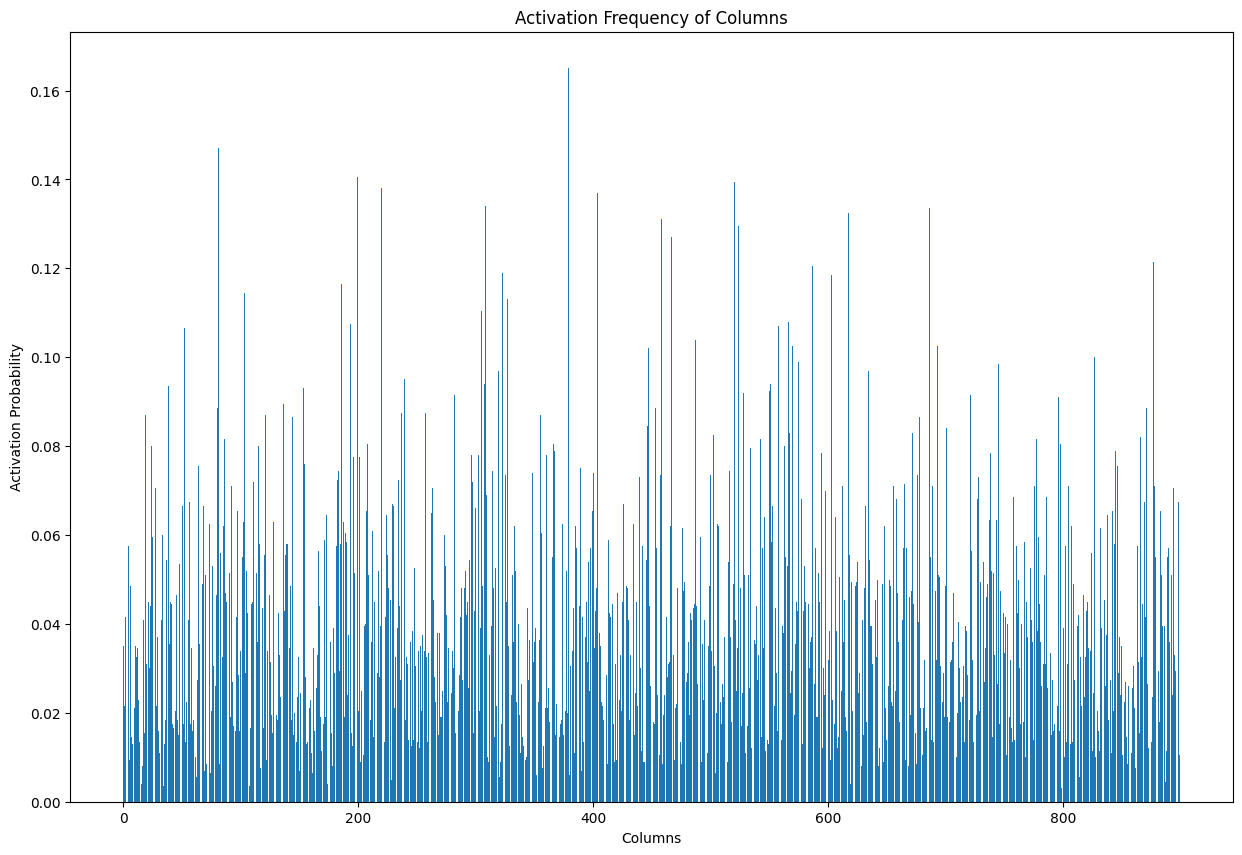

In [17]:
plot_activation_prob(sp.cols_activation_freq,sp.count)

Протестируй разные значения `output_size` - например, $[10^2, 15^2,..., 55^2, 60^2]$ и отрисуй график зависимости [качества классификации, но можешь и времени работы тоже].

Сравни с результатами без бустинга

CPU times: total: 0 ns
Wall time: 0 ns
Score: 73.3% for n = 1000
Score: 81.1% for n = 1000
Score: 83.7% for n = 1000
Score: 84.6% for n = 1000
Score: 89.0% for n = 1000
Score: 88.3% for n = 1000
Score: 88.4% for n = 1000
Score: 89.4% for n = 1000
Score: 90.5% for n = 1000
Score: 89.2% for n = 1000
Score: 89.8% for n = 1000


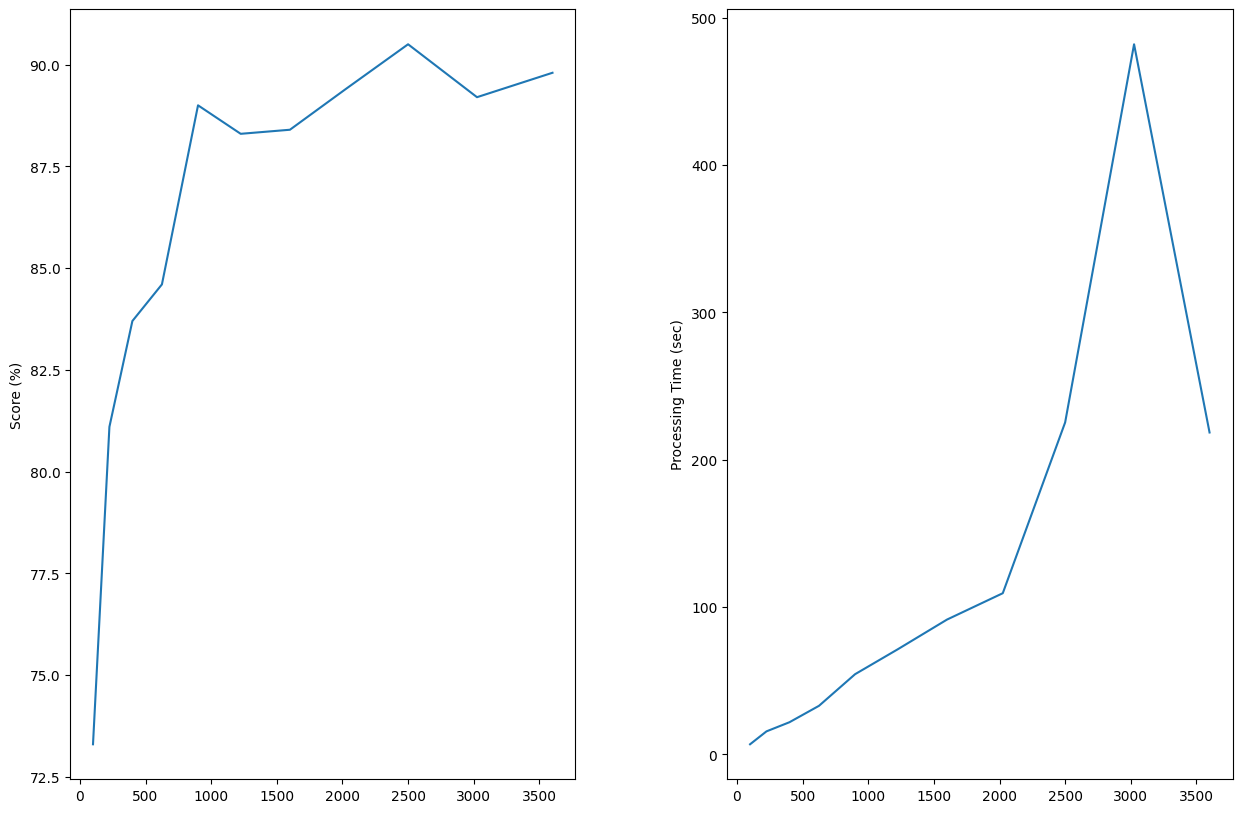

In [18]:
%%time
np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

output_sizes = [i**2 for i in range(10,65,5)]

scores = []
processing_time = []
for output_size in output_sizes:
  sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=output_size,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
    )
  start_time = time.time()
  score = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
  processing_time.append((time.time()-start_time))
  scores.append(score*100)

quality_vs_output_size(output_sizes,scores,processing_time)

___
__[Опционально]__ можешь ради интереса поиграться с таким параметром как `receptive_field_sparsity`. Возьми в качестве выходного размера `output_size` = $50^2$ и проверь результаты на разных значениях параметра $[0.4, 0.5, ..., 1.0]$ и построй график зависимости.

Score: 90.2% for n = 1000
Score: 89.3% for n = 1000
Score: 89.3% for n = 1000
Score: 89.6% for n = 1000
Score: 88.7% for n = 1000
Score: 89.3% for n = 1000
Score: 89.1% for n = 1000


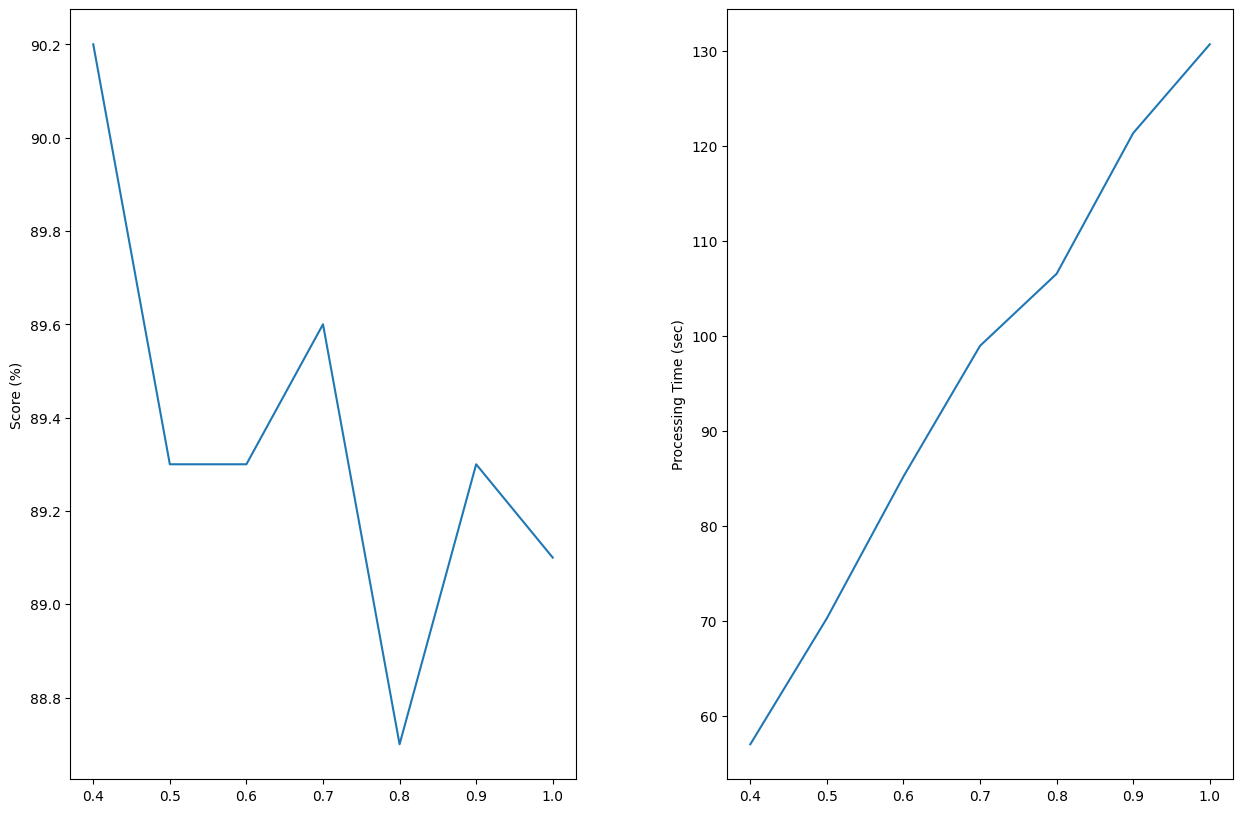

In [19]:
np.random.seed(seed)
n = 1000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

receptive_field_sparsity = np.arange(0.4,1.1,0.1)

scores = []
processing_time = []
for rfs in receptive_field_sparsity:
  sp = LearnableSpatialPooler(
      input_size=train_images[0].size,
      output_size=50**2,
      permanence_threshold=.5,
      output_sparsity=.04,
      synapse_permanence_deltas=(.1, .03),
      receptive_field_sparsity=rfs
      )
  start_time = time.time()
  score = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
  processing_time.append((time.time()-start_time))
  scores.append(score*100)


quality_vs_output_size(receptive_field_sparsity,scores,processing_time)

Score: 90.2% for n = 1000
Score: 88.9% for n = 1000
Score: 89.8% for n = 1000
Score: 89.5% for n = 1000
Score: 90.0% for n = 1000
Score: 89.4% for n = 1000
Score: 89.2% for n = 1000


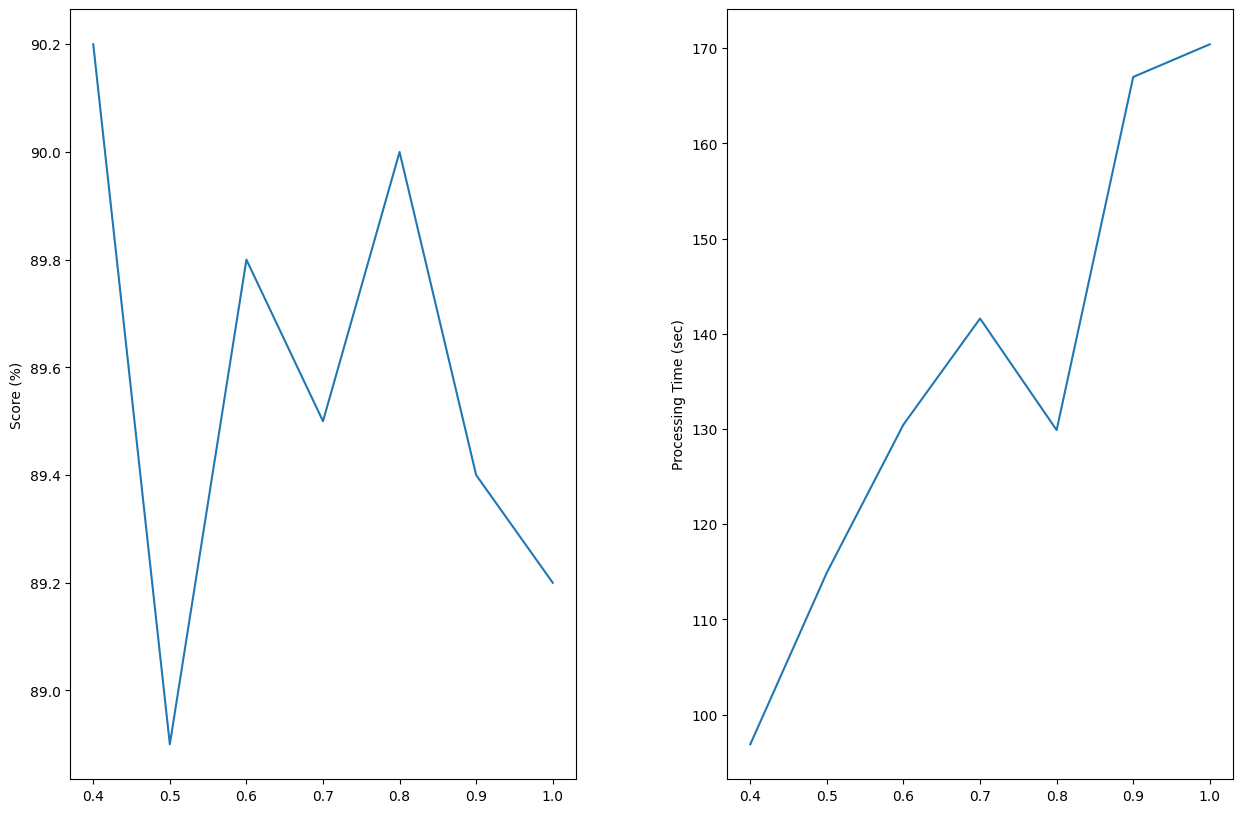

In [20]:
scores = []
processing_time = []
for rfs in receptive_field_sparsity:
  sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=50**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=rfs,
    max_boost_factor=2,
    boost_sliding_window=1000
    )
  start_time = time.time()
  score = test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)
  processing_time.append((time.time()-start_time))
  scores.append(score*100)

quality_vs_output_size(receptive_field_sparsity,scores,processing_time)

## 07. TESTING

Дальше просто сравнительное тестирование получившихся результатов.

In [ ]:
n = 60000
x_tr, y_tr = train_images[:n], train_labels[:n]
x_tst, y_tst = test_images[:n], test_labels[:n]

In [21]:
%%time

def test_bare_classification(x_tr,  y_tr, x_tst, y_tst):
    linreg = LogisticRegression(tol=.05, max_iter=LBFGS_MAX_ITER, multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=3)
    linreg.fit(x_tr, y_tr)

    score = linreg.predict(x_tst) == y_tst
    score = score.mean()
    print(f'Score: {100 * score:.1f}%')
    return score

np.random.seed(seed)
# 92.11; 38s
test_bare_classification(x_tr, y_tr, x_tst, y_tst)

Score: 87.4%
CPU times: total: 78.1 ms
Wall time: 2.63 s


0.874

In [22]:
%%time

np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
)
# 89.3; 72 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 86.3% for n = 1000
CPU times: total: 35.1 s
Wall time: 38.9 s


0.863

In [23]:
%%time

np.random.seed(seed)
sp = LearnableSpatialPooler(
    input_size=train_images[0].size,
    output_size=50**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
)
# 93.15; 221 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 89.7% for n = 1000
CPU times: total: 1min 44s
Wall time: 1min 49s


0.897

In [24]:
%%time

np.random.seed(seed)
sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=30**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 91.15; 86 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 86.6% for n = 1000
CPU times: total: 54.1 s
Wall time: 1min


0.866

In [25]:
%%time

np.random.seed(seed)
sp = BoostedSpatialPooler(
    input_size=train_images[0].size,
    output_size=50**2,
    permanence_threshold=.5,
    output_sparsity=.04,
    synapse_permanence_deltas=(.1, .03),
    receptive_field_sparsity=.8,
    max_boost_factor=2,
    boost_sliding_window=1000
)
# 94.44; 238 s
test_classification_with_sp(x_tr, y_tr, x_tst, y_tst, sp)

Score: 89.7% for n = 1000
CPU times: total: 2min 26s
Wall time: 2min 33s


0.897

## Improve SP implementation

Теперь, когда у тебя есть готовая реализация SpatialPooler, время для улучшения/ускорения реализации. Попробуй выполнить задания ниже.

1. **Векторизация**: нужна векторизованная реализация, которая будет эффективно вычислять overlap score, boosting и все остальное. Важно ответить себе на вопрос, как организовать хранение рецептивных полей нейронов SP, как делать pattern matching для входного паттерна, как эффективно делать шаг обновления. Придется поиграться с разными реализациями, измеряя скорость их работы. Ну и вообще, сейчас самое время причесать свою реализациюи довести ее до финального вида.

2. **Разреженные рецептивные поля**: можно ли улучшить качество работы SP, если уменьшить размеры рецептивных полей его нейронов (но возможно увеличив количество нейронов)? Зафиксируй какое-нибудь определенный лимит времени работы SP и попробуй варьировать эти два гиперпараметра (`receptive_field_sparsity` и `output_size`), чтобы оставаться в рамках лимита. Нарисуй график зависимости качества от этих двух параметров.

3. [**СЛОЖНО**] **Newborn-stage**: В [On the importance of the newborn stage when learning patterns with the Spatial Pooler](https://link.springer.com/article/10.1007/s42979-022-01066-4) описана идея, что бустинг, вообще говоря, имеет и негативную сторону — он имеет смысл лишь на ранних стадиях формирования рецептивных полей нейронов. Но далее он только влечет к нестабильности (способствует дрифту кодировки на выходе из SP за счет переучивания его нейронов). Предлагается взять эту идею (статью подробно читать для этого не нужно) и добавить newborn stage в SP. Для этого сделай отдельную реализацию, чтобы у тебя была отдельная финальная версия без этой фичи, и отдельная уже с. Newborn stage будет разделен на K этапов, в процессе которых
    1. Бустинг будет постепенно снижаться (например, линейно) к нулю
    2. Рецептивные поля будут уменьшаться. Таким образом SP будет инициализироваться с большими рецептивными полями, но в процессе newborn stage они будут постепенно пруниться до целевых значений. Это позволит нам во взрослой стадии иметь быстрый (за счет маленьких рецептивных полей) SP с хорошо настроенными рецептивными полями, из-за чего качество будет не сильно хуже, чем если бы мы не прунили.
   
   Протестируй данную реализацию с разными настройками начального и конечного размера рецептивных полей.